## Installing Dependencies

In [1]:
!pip install tensorflow

## Importing Packages

In [2]:
import pandas as pd
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [3]:
# Load and prepare the data
data = pd.read_csv('clean_data.csv')

# Check if columns exist before dropping
columns_to_drop = ['Unnamed: 0', 'Unnamed: 0.1']
for column in columns_to_drop:
    if column in data.columns:
        data.drop(columns=[column], inplace=True)

## Data Preprocessing

In [4]:
# Separating categorical and numerical features
categorical_data = data.select_dtypes(include=['object']).copy()
numerical_data = data.select_dtypes(include=['int64', 'float64']).copy()

# One-hot encoding for categorical features
encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(categorical_data)

# Normalization for numerical features
scaler = MinMaxScaler()
numerical_scaled = scaler.fit_transform(numerical_data.values)

## Autoencoder Setup

In [5]:
feature_vectors = np.hstack([categorical_encoded.toarray(), numerical_scaled])
# Setting up the autoencoder
input_dim = feature_vectors.shape[1]
encoding_dim = 64  # Encoded representation size

In [6]:
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)
autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

In [7]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(feature_vectors, feature_vectors, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)
# Train the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
history = autoencoder.fit(feature_vectors, feature_vectors, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

# Use the autoencoder to reconstruct the feature vectors
reconstructed_vectors = autoencoder.predict(feature_vectors)

car_embeddings = encoder.predict(feature_vectors)

Epoch 1/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 432us/step - loss: 0.0354 - val_loss: 0.0029
Epoch 2/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 404us/step - loss: 0.0017 - val_loss: 0.0020
Epoch 3/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step - loss: 7.9875e-04 - val_loss: 0.0018
Epoch 4/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - loss: 4.0180e-04 - val_loss: 0.0017
Epoch 5/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step - loss: 2.6406e-04 - val_loss: 0.0016
Epoch 6/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 409us/step - loss: 1.8971e-04 - val_loss: 0.0015
Epoch 7/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 411us/step - loss: 1.2656e-04 - val_loss: 0.0014
Epoch 8/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step - loss: 9.3066e-05 - val_loss: 0.0014
Epoch 9/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 407us/step - loss: 9.0113e-05 - val_loss: 0.0014
Epoch 10/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step - loss: 7.9361e-05 - val_loss: 0.0014
Epoch 11/100
1785/1785 ━━━━━━━━━━━━━━━━━━━━ 1s 413us/step

## User Input Widgets

In [8]:
# Create widgets for user input
price_input = widgets.FloatText(value=25000, description='Price:', disabled=False)
mileage_input = widgets.FloatText(value=30, description='Mileage:', disabled=False)
transmission_input = widgets.Dropdown(options=data['transmission'].unique(), description='Transmission:')
fuel_type_input = widgets.Dropdown(options=data['fuelType'].unique(), description='Fuel Type:')

## Recommendation Engine
### A function to find similar cars is defined, using cosine similarity for numerical embeddings and filtering based on categorical matches, price, and mileage.

In [9]:
def find_similar(embedding, embeddings, input_price, input_mileage, input_transmission, input_fuel_type, n=5):
    # Calculate the cosine similarity of the numerical embeddings
    numerical_similarities = cosine_similarity(embedding.reshape(1, -1), embeddings).flatten()
    
    # Create a boolean mask for the categorical features
    categorical_mask = (data['transmission'] == input_transmission) & (data['fuelType'] == input_fuel_type)
    
    # Apply the mask to the numerical similarities
    masked_similarities = numerical_similarities * categorical_mask
    
    # Only consider cars with a price less than or equal to the input price
    price_mask = data['price'] <= input_price
    
    # Only consider cars with a mileage greater than or equal to the input mileage
    mileage_mask = data['mpg'] >= input_mileage
    
    # Apply the price and mileage masks to the similarities
    masked_similarities = masked_similarities * price_mask * mileage_mask
    
    # Get the indices of the cars that meet the criteria
    indices = np.where(masked_similarities > 0)[0]
    
    # Sort the indices by the difference between the car's price and the input price (in ascending order)
    # and then by mileage (in descending order)
    indices = sorted(indices, key=lambda index: (abs(data.iloc[index]['price'] - input_price), -data.iloc[index]['mpg']))
    
    # Return the top N indices
    return indices[:n]

In [10]:
def recommend_similar_cars():
    input_price = price_input.value
    input_mileage = mileage_input.value
    input_transmission = transmission_input.value
    input_fuel_type = fuel_type_input.value
    
    placeholder_array = np.zeros(numerical_scaled.shape[1])
    for i, column in enumerate(numerical_data.columns):
        placeholder_array[i] = numerical_data[column].median()
    placeholder_array[numerical_data.columns.get_loc("price")] = input_price
    placeholder_array[numerical_data.columns.get_loc("mpg")] = input_mileage
    normalized_input = scaler.transform([placeholder_array])
    
    differences = numerical_scaled - normalized_input
    distances = np.linalg.norm(differences, axis=1)
    closest_car_index = np.argmin(distances)
    
    similar_indices = find_similar(car_embeddings[closest_car_index], car_embeddings, input_price, input_mileage, input_transmission, input_fuel_type)
    recommended_cars = data.iloc[similar_indices]
    
    # Shuffle the recommended cars to get a variety of makes
    recommended_cars = recommended_cars.sample(frac=1)
    
    # Sort the recommended cars by mileage in descending order
    recommended_cars = recommended_cars.sort_values('mpg', ascending=False)
    
    print("Based on your input, here are suggested cars:")
    print(recommended_cars)

In [11]:
# Define the function that will be called when the button is clicked
def on_button_clicked(b):
    with output:
        output.clear_output()
        recommend_similar_cars()
button = widgets.Button(description="Recommend Cars")
button.on_click(on_button_clicked)

# Display widgets for user input
output = widgets.Output()
display(price_input, mileage_input, transmission_input, fuel_type_input, button, output)

FloatText(value=25000.0, description='Price:')

FloatText(value=30.0, description='Mileage:')

Dropdown(description='Transmission:', options=('Automatic', 'Semi-Auto', 'Manual', 'Other'), value='Automatic'…

Dropdown(description='Fuel Type:', options=('Petrol', 'Diesel', 'Hybrid', 'Other', 'Electric'), value='Petrol'…

Button(description='Recommend Cars', style=ButtonStyle())

Output()

In [12]:
# After training the autoencoder, use it to reconstruct the feature_vectors
reconstructed_vectors = autoencoder.predict(feature_vectors)

# Calculate Mean Squared Error between original and reconstructed vectors
mse = np.mean(np.power(feature_vectors - reconstructed_vectors, 2), axis=1).mean()
print("Mean Squared Error:", mse)

# Calculate a pseudo 'accuracy' for illustration (not a standard practice for autoencoders)
accuracy_percentage = 100 * (1 - mse)  # This assumes the worst case mse of 1
print("Reconstruction 'Accuracy' Percentage:", accuracy_percentage)


2231/2231 ━━━━━━━━━━━━━━━━━━━━ 1s 251us/step
Mean Squared Error: 0.0002762146616024029
Reconstruction 'Accuracy' Percentage: 99.97237853383976


## Evaluation Metrics and Plot

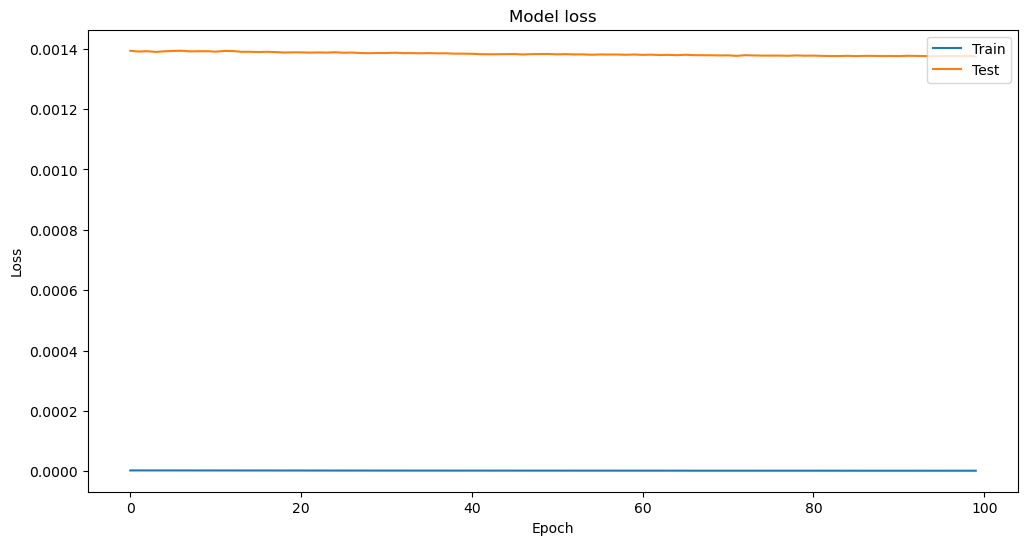

In [13]:
import matplotlib.pyplot as plt
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

**In conclusion, the accuracy of our autoencoder based car recommendation is roughly 99.97% and thus is able to recommend cars to the user based on user preferences effectively.**